# Investigating no-show appointments dataset
## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

This dataset is a collected information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. the first step is to load all of the essential libraries, modelules and the dataset itself, then spectating the data and getting basic information about it.

## Questions to be answered:
<ul style="font-size: 20px; line-height: 150%">
    <li> <b>Q1: How is the demographic-based features affect the presence of the patient at the appointment ("Gender", "Age")?</b></li>
    <li><b>Q2: How is the duration from the schedling to the appointment is related?</b></li>
</ul>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("fivethirtyeight")

In [2]:
# Loading the data and inspecting the first 5 rows
df = pd.read_csv("no_show.csv")
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


### Step 1: Clearing the data
        removing duplicates, handling nulls, filting the features that seems irrelvent.

In [3]:
df.shape

(110527, 14)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PatientId       110527 non-null  float64
 1   AppointmentID   110527 non-null  int64  
 2   Gender          110527 non-null  object 
 3   ScheduledDay    110527 non-null  object 
 4   AppointmentDay  110527 non-null  object 
 5   Age             110527 non-null  int64  
 6   Neighbourhood   110527 non-null  object 
 7   Scholarship     110527 non-null  int64  
 8   Hipertension    110527 non-null  int64  
 9   Diabetes        110527 non-null  int64  
 10  Alcoholism      110527 non-null  int64  
 11  Handcap         110527 non-null  int64  
 12  SMS_received    110527 non-null  int64  
 13  No-show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


<p style="color:red">the data set doesn't seem to have null values at all</p>

<h3> from the first glance it seems like the "PatientId" &	"AppointmentID" are useless given that the analytics will be descriptive rather than identificational. So it will not affect whether the patient is present more than once, just for the sake of this specific analysis. Finally the analysis won't be interested in the health conditions of the patients so medical features also are to be dropped</h3>

In [5]:
df.drop(columns=["PatientId", "AppointmentID", "Diabetes", "Alcoholism", "Handcap"], inplace=True)

In [6]:
df.duplicated().sum()

636

 There seems to be a lot of duplicates, so they should be excluded.

In [7]:
# Removing duplicated Values
df.drop_duplicates(inplace=True)
print(f"new shape = {df.shape}, duplicated rows now are {df.duplicated().sum()}")

new shape = (109891, 9), duplicated rows now are 0


 there is a negative "Age" That should be dealt with so we will just drop it.

In [8]:
print((df.Age <0).sum())
df = df[df.Age >= 0]
df.Age.min()   # Confirming the change

1


0

Casting the scheduledDay and the appointmentDay to be DateTime

In [9]:
df.AppointmentDay = pd.to_datetime(df.AppointmentDay, format="%Y-%m-%d")
df.ScheduledDay = pd.to_datetime(df.ScheduledDay, format="%Y-%m-%d")

Renaming  the "No-show" feature so that it could be accessed easily as an attribute and its values would be more descriptive.

In [10]:
df.rename(columns= {'No-show': 'No_show'}, inplace=True)
df.No_show.replace(['No', 'Yes'], ['showed', 'missed'], inplace=True)

Reviewing the dataset to confirm changes

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109890 entries, 0 to 110526
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype              
---  ------          --------------   -----              
 0   Gender          109890 non-null  object             
 1   ScheduledDay    109890 non-null  datetime64[ns, UTC]
 2   AppointmentDay  109890 non-null  datetime64[ns, UTC]
 3   Age             109890 non-null  int64              
 4   Neighbourhood   109890 non-null  object             
 5   Scholarship     109890 non-null  int64              
 6   Hipertension    109890 non-null  int64              
 7   SMS_received    109890 non-null  int64              
 8   No_show         109890 non-null  object             
dtypes: datetime64[ns, UTC](2), int64(4), object(3)
memory usage: 8.4+ MB


<a id='eda'></a>
# Step 2: Data Exploration

A Utility Function to be used to avoid Repetition, used to minimize the graphing procedures and code.

In [12]:
def graph_ratio_util(df=None, is_grp=False, **kwargs):
    df_ratio = None
    if not is_grp:   # if the dataframe wasn't a groupby Object
        if len(df.shape) == 1:   # if the obkect was a series
            df_ratio = df.value_counts()
        else:     # if the object was a Dataframe
            df_ratio = df.apply(lambda x: x.value_counts())
    else:
        df_ratio = df.count()
    df_ratio.plot(**kwargs)

## The following cells are trying to answer the first proposed question.

#### 1- Gender

 investigate the ratio of the attendent patients for each gender

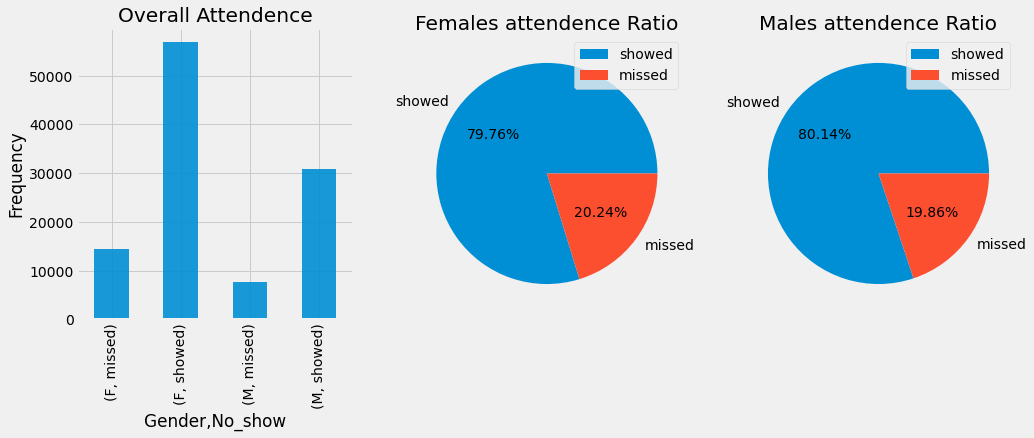

In [13]:
df_fGrp = df[df.Gender == 'F']   # Female Patients Data
df_mGrp = df[df.Gender == 'M']   # Males Patient Data

f, axs = plt.subplots(1, 3, figsize=(15,5))

# overall show
graph_ratio_util(df=df.groupby(['Gender', 'No_show']).Gender, kind='bar', is_grp=True, ax=axs[0], subplots=True, alpha=0.9)

# females Ratio
graph_ratio_util(df=df_fGrp['No_show'], kind='pie', ax=axs[1], subplots=True, legend=True, autopct='%1.2f%%');

# males_ration
graph_ratio_util(df=df_mGrp['No_show'], kind='pie', ax=axs[2], subplots=True, legend=True, autopct='%1.2f%%');

titles= ["Overall Attendence", "Females attendence Ratio", "Males attendence Ratio"]
for i in range(3):
    axs[i].set_title(titles[i])
    axs[i].set_ylabel('')
axs[0].set_ylabel("Frequency");

<p style="color: green; font-size: 16px;"> ! Gender doesn't seem to affect the show-at-appointment, both genders seem to have, fairly, similar attendence ratios"</p>

## 2- Age

plotting the age distribution for the patient who have attended the appointment

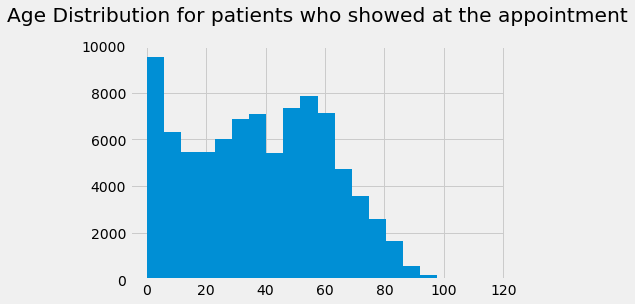

In [14]:
df[df.No_show == 'showed'].Age.hist(bins=20);
plt.title("Age Distribution for patients who showed at the appointment", y = 1.08);

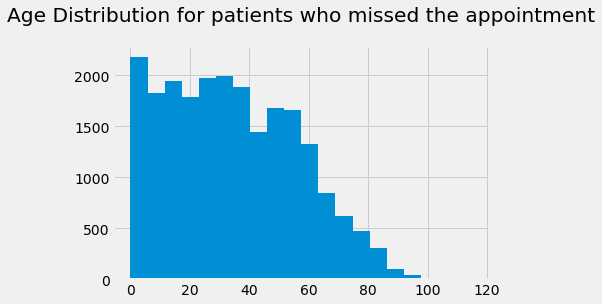

In [15]:
df[df.No_show == 'missed'].Age.hist(bins=20);
plt.title("Age Distribution for patients who missed the appointment", y = 1.08);

<p style="color: green; font-size: 16px;"> !  it looks like the Age has a slight effct, barely no effect at all, on the show-at-appointment feature. Except that the people younger than 50 are more likely to miss, which is logical. considering that, intuitively, older people are more likely to attend their appointments considering their unstable health conditions.</p>

## The following cells are trying to answer the second proposed question.

creating a series with the difference of ScheduledDay and Appointment Day with the no_show (by day)

In [16]:
diff_dates = pd.DataFrame()
diff_dates['difference'] = (df.AppointmentDay.sub(df.ScheduledDay) / np.timedelta64(1, 'D')).apply(int)
diff_dates['No_show'] = df.No_show
diff_dates.head()

,difference,No_show
0,0,showed
1,0,showed
2,0,showed
3,0,showed
4,0,showed


!!!! There seems to be a Wrong Entries where the scheduledDay is after the appointmentDay, so we will just drop them

In [17]:
diff_dates = diff_dates[diff_dates.difference >= 0]

Extracting patients who missed the appointment.

In [18]:
grp_missed = diff_dates[diff_dates.No_show == 'missed'].groupby('difference')
grp_showed = diff_dates[diff_dates.No_show == 'showed'].groupby('difference')

In [19]:
grp_showed = diff_dates[diff_dates.No_show == 'showed'].groupby('difference')

plotting the results of patients who missed the appointment

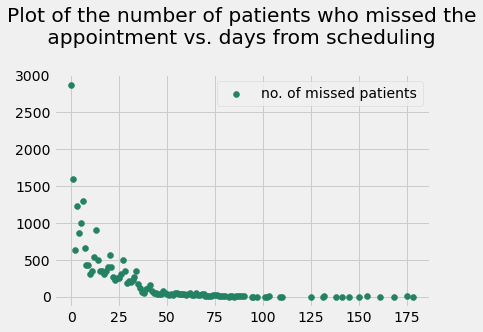

In [20]:
plt.scatter(grp_missed.groups.keys(), grp_missed.size(), c='#248163', label='no. of missed patients');
plt.legend()
plt.title('Plot of the number of patients who missed the\n appointment vs. days from scheduling ', pad=30);

Visualizing the count of patient who attended vs. days difference.

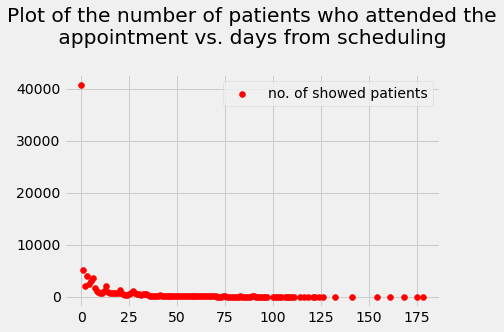

In [21]:
plt.scatter(grp_showed.groups.keys(), grp_showed.size(), c='#F00', label='no. of showed patients');
plt.legend()
plt.title('Plot of the number of patients who attended the\n appointment vs. days from scheduling ', pad=30);

# Conclusion

## Regarding the demographics (Q1).
<ol style="font-size:16px; color: #6482B4"> 
    <li> As shown, gender can't be used as a feature to build a reliable model, because it seems rather irrelevent to the show-at-appointment</li>
    <li> There appears to be a relation between the age of the patient and his/her ability to show at the appointment, though very weak relation. Basically, younger patients are more likely to miss their appoinments (older than 50 years old) than younger patients </li>
    
</ol>

<h2> As for the days difference from the schduling to the appointment (Q2). </h2>

<ol style="font-size:16px; color: #6482B4">
    <li>Patients that reserved an appointment for far dates are more likely to miss their appoinments</li>
    <li>Namely, as the difference between the scheduling day and the appointment day is less, the less likely that the patient will miss it.</li>
</ol>
<h4 style="font-size:20px; color: #6482B4; line-height: 150%">one conclusion could be: the less time a patient has the more will he be prepared for the appointment(by reschduling his businesses, postponing meetings...etc.</h4>

Viualizing both showing and missing the appointment

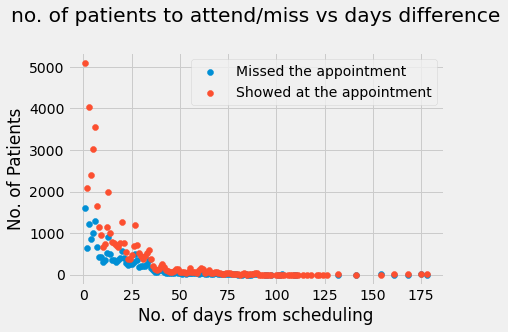

In [22]:
total_attend = diff_dates.groupby(['difference', 'No_show'])
# a way around to organize the show and miss data in a dataframe
total_attend = total_attend.size().unstack()
# removing an outlier in the show data to help comparing the data
total_attend = total_attend[total_attend.showed < 30000]
# getting the x-axis (difference)
index = pd.Series(total_attend.index)
#plotting the data
plt.scatter(index, total_attend.missed, label='Missed the appointment')
plt.scatter(index, total_attend.showed, label='Showed at the appointment');
plt.xlabel('No. of days from scheduling')
plt.ylabel('No. of Patients')
plt.title('no. of patients to attend/miss vs days difference', pad=30)
plt.legend();

## Limitaions:

<ul style="font-size: 16px; line-height: 30px;">
    <li>For the demographic data: the available features, unfortunately, <b>weren't sufficient to build a concrete colclusion</b>.  A more convenient feature was the address of the patient or the neighborhood, so that more variables would have been considered such as the distances, and both age and distance between the patient and the hospital, which could have a large influence of the results.</li>
    <li><b>The Number of samples, apparently, wasn't adequate</b>. For a country like Brazil with <b>+200 million</b> population a sample of <b>100k is about 0.05%</b> which is remarkably small to be used to drive a reliable statistic or a parameter.</li>
    <li>The difference/attendence realtion in this analysis is the most reliable, and could build a good model. Basically, because the percetages of the percentage patients refelects the national statistics observed in the Brazilian population. On the other hand, the data shouldn't be generalized because the medical services varies from a country to another, so this could be used as a national model not a global one.</li>
</ul>

In [23]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0